In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
print("Loading training dataset...")
data = pd.read_csv("Train.csv")
print("Dataset loaded successfully!")
print("Shape:", data.shape)
data.head()

Loading training dataset...
Dataset loaded successfully!
Shape: (42574, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
if data.isnull().sum().sum() > 0:
    print("Missing values found — filling with 0")
    data = data.fillna(0)

Missing values found — filling with 0


/tmp/ipython-input-2745656652.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="crest")


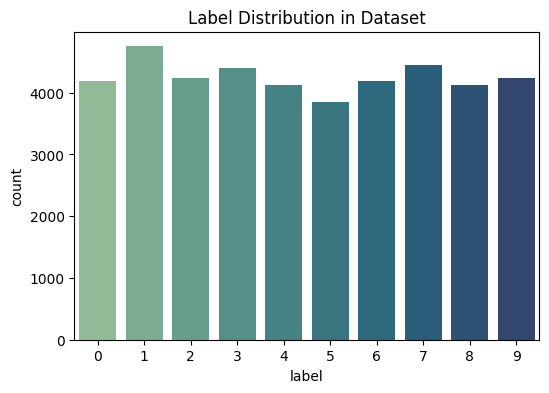

Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


In [5]:
label_col = "label" if "label" in data.columns else data.columns[0]
y = data[label_col]
X = data.drop(columns=[label_col])

# Confirm label distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="crest")
plt.title("Label Distribution in Dataset")
plt.show()

print("Unique labels:", sorted(y.unique()))

In [6]:
# Convert to numpy array (float32 for TensorFlow)
X = X.to_numpy(dtype="float32") / 255.0

# Verify image size (should be 784 = 28x28)
assert X.shape[1] == 784, f"Expected 784 features, got {X.shape[1]}"

# Reshape into 28x28 grayscale images
X = X.reshape(-1, 28, 28, 1)

# One-hot encode labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

# Train-validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (34059, 28, 28, 1), Validation set: (8515, 28, 28, 1)


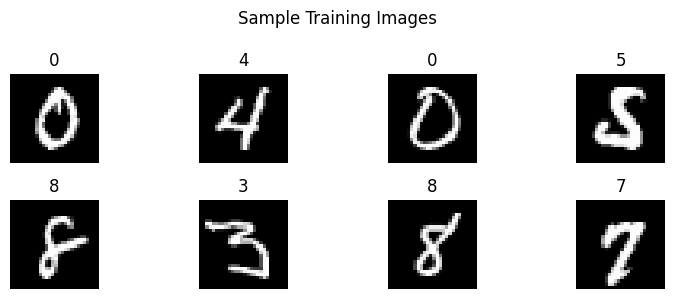

In [7]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(np.argmax(y_train[i]))
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()

In [8]:
model = Sequential([
    Input(shape=(28, 28, 1)),

    # Convolution Block 1
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Convolution Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Convolution Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,442 (947.04 KB)

 Trainable params: 241,994 (945.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1
)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 87s 156ms/step - accuracy: 0.8401 - loss: 0.5519 - val_accuracy: 0.9595 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 2/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.9758 - loss: 0.0848 - val_accuracy: 0.9876 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 3/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 142s 157ms/step - accuracy: 0.9836 - loss: 0.0585 - val_accuracy: 0.9876 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 4/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 147s 167ms/step - accuracy: 0.9869 - loss: 0.0423 - val_accuracy: 0.9866 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 5/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9884 - loss: 0.0384
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
533/533 ━━━━━━━━━━━━━━━━━━━━ 136s 155ms/step - accuracy: 0.9884 - loss: 0.0384 - val_accuracy: 0.9880 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 6/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 143s 157ms/step - accuracy: 0

267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9893 - loss: 0.0496

Validation Accuracy: 99.11%


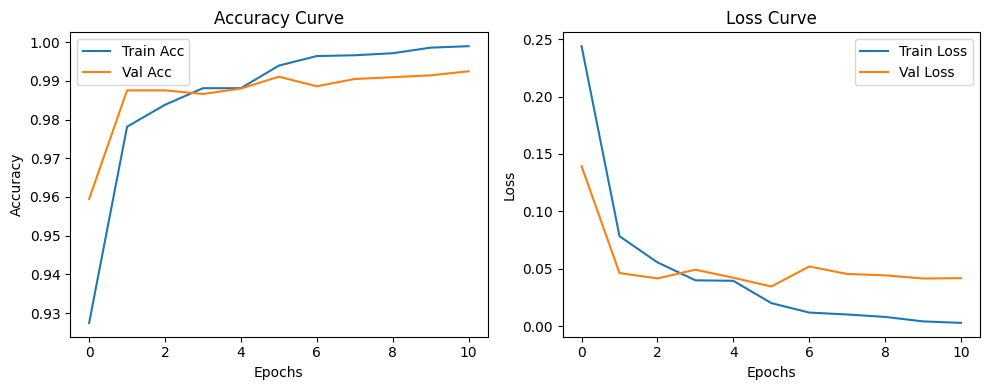

In [12]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")

# Plot Accuracy and Loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy Curve"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss Curve"); plt.xlabel("Epochs"); plt.ylabel("Loss")

plt.tight_layout()
plt.show()

267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


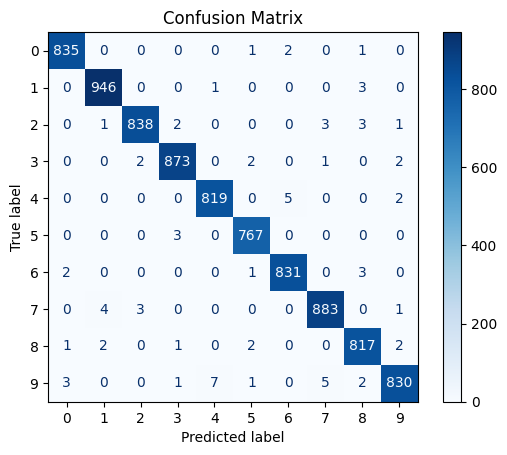

In [13]:
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [16]:
print("\nGenerating predictions on internal test split...")
# X_test and y_test already exist from train_test_split earlier
predictions = np.argmax(model.predict(X_val), axis=1)

print("Predictions generated successfully!")
print(f"Example predictions: {predictions[:10]}")


Generating predictions on internal test split...
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Predictions generated successfully!
Example predictions: [4 8 0 6 1 2 9 3 9 1]


In [17]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predictions)+1),
    "Label": predictions
})
submission.to_csv("digit_predictions.csv", index=False)
print("Submission file saved as 'digit_predictions.csv'")

model.save("digit_recognition_cnn_model.h5")
print("Model saved as 'digit_recognition_cnn_model.h5'")

Submission file saved as 'digit_predictions.csv'
Model saved as 'digit_recognition_cnn_model.h5'
